# Aplicação do método de One Class Classification para o banco de dados Burkitt

Inicialmente iremos considerar a hipótese de que não existe relação entre tempo e espaço, a partir disso construiremos uma série de modelos utilizando como base de dados a seguinte transformação da base original: As covariáveis serâo caracaterísticas calculadas a partir do banco de dados, em um primeiro momento será considerado como covariável $V_1$: Distância euclidiana da observação no tempo $t_i$ até a observação no tempo $t_{i-1}$, $V_2$: Diferença entre $t_i$ e $t_k$, onde $k < i$ e $t_k$ equivale ao tempo da ultima ocorrência na circunferência de raio $\rho$ com centro $(x_i,y_i)$, considerando $H_0$ como verdadeiro, faremos uma série de permutações entre os indices de tempo das coordenadas de forma a testar se realmente nâo há anomalias ao inserir as variáveis sem a permutação nos modelos treinados.

### Bibliotecas e funções

In [1]:
#%pip install -U scikit-learn
import time
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from sklearn.datasets import make_blobs
import matplotlib.animation as animation
from sklearn import svm
from sklearn.datasets import make_moons, make_blobs
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import SGDOneClassSVM
from sklearn.kernel_approximation import Nystroem
from sklearn.pipeline import make_pipeline
from scipy.spatial import distance
from scipy.spatial.distance import euclidean
%matplotlib inline

##### SIMULACAO DE DADOS PARA TESTAR ACCURACY


In [42]:
# Definir parâmetros do dataset
T = 300  # Número total de observações
cluster_start = 600  # Tempo de início do intervalo de tempo do cluster
cluster_end = 800  # Tempo de fim do intervalo de tempo do cluster
cluster_proportion = 0.3  # Proporção de observações no cluster
tempo_maximo = 1000  # Tempo máximo para gerar os valores aleatórios

# Gerar o tempo (t)
np.random.seed(0)
times = np.random.randint(0, tempo_maximo, size=T)

# Gerar as coordenadas x, y de forma aleatória
np.random.seed(0)
x = np.random.uniform(0, 600, size=T)
y = np.random.uniform(0, 600, size=T)

# Criar um array de índices para selecionar as observações dentro do intervalo do cluster
cluster_indices = np.where((times >= cluster_start) & (times <= cluster_end))[0]

# Calcular o tamanho máximo do cluster com base na proporção desejada
cluster_size_max = int(T * cluster_proportion)

# Verificar se o número de observações no intervalo do cluster é menor ou igual ao tamanho máximo do cluster
if len(cluster_indices) <= cluster_size_max:
    selected_indices = cluster_indices
else:
    # Embaralhar os índices para garantir que selecione aleatoriamente o tamanho desejado
    np.random.shuffle(cluster_indices)

    # Selecionar os índices correspondentes ao tamanho máximo do cluster
    selected_indices = cluster_indices[:cluster_size_max]

# Criar a coluna "cluster" com base nos índices selecionados
is_cluster = np.zeros(T, dtype=bool)
is_cluster[selected_indices] = True

# Gerar as coordenadas x, y do cluster
cluster_x = np.random.normal(loc=100, scale=5, size=len(selected_indices))
cluster_y = np.random.normal(loc=200, scale=5, size=len(selected_indices))

# Criar cópias das coordenadas x, y para preservar as observações não cluster
x_clustered = np.copy(x)
y_clustered = np.copy(y)

# Substituir as coordenadas x, y pelo cluster nas observações dentro do intervalo
x_clustered[selected_indices] = cluster_x
y_clustered[selected_indices] = cluster_y

# Criar o DataFrame com as colunas x, y, t e cluster
df = pd.DataFrame({'x': x_clustered, 'y': y_clustered, 't': times, 'cluster': is_cluster})

# Exibir o DataFrame
df = df.sort_values('t')
df

,x,y,t,cluster
8,578.197656,435.356619,9,False
285,88.884517,148.439253,11,False
179,19.103358,271.093010,11,False
207,272.218107,29.214178,19,False
153,369.335739,63.543693,23,False
...,...,...,...,...
297,517.314910,282.389370,979,False
41,262.219172,118.232568,984,False
277,479.521552,531.782800,998,False
84,339.960873,492.460272,999,False


In [48]:
x = np.random.uniform(0, 1, 1000)
y = np.random.uniform(0, 1, 1000)
t = np.random.uniform(0, 1, 1000)
xc = np.random.uniform(0.95, 1, 100)
yc = np.random.uniform(0.95, 1, 100)
tc = np.random.uniform(0.95, 1, 100)

df = pd.DataFrame(np.vstack((np.column_stack((x, y, t)), np.column_stack((xc, yc, tc)))))
df.columns = ['x', 'y', 't']

In [49]:
df

,x,y,t
0,0.582412,0.171089,0.376607
1,0.201229,0.999957,0.150551
2,0.448203,0.682216,0.084899
3,0.472077,0.548052,0.375876
4,0.011337,0.795108,0.625699
...,...,...,...
1095,0.998051,0.989024,0.999831
1096,0.961448,0.969664,0.950056
1097,0.950980,0.973854,0.991403
1098,0.996085,0.982968,0.966314


### Função para criacao das variáveis sintéticas no banco de dados

In [10]:
def criar_variaveis(df, rho=20):
    df = df.reset_index(drop=True)
    df[['var1']] = 0
    df[['var2']] = 0
    df[['var3']] = 0
    
    for i in range(len(df.index) - 1):
        # VARIAVEL 1, DISTANCIA ATE A ULTIMA OCORRENCIA
        a = np.array((df.loc[i + 1, 'x'], df.loc[i + 1, 'y']))
        b = np.array((df.loc[i, 'x'], df.loc[i, 'y']))
        df.loc[i + 1, 'var1'] = np.linalg.norm(a - b)
    for i in range(30, int(df['t'].max()) + 1):
        # VARIAVEL 2, DIFERENCA DE TEMPO ATE A ULTIMA OCORRENCIA EM UM DETERMINADO RAIO, COM UMA JANELA DE TEMPO MAXIMA
        center = np.array((df.loc[df['t'] == i, 'x'].values, df.loc[df['t'] == i, 'y'].values))
        j = i - 1

        while j >= (i - 30):
            point = np.array((df.loc[df['t'] == j, 'x'].values, df.loc[df['t'] == j, 'y'].values))

            if len(point[0]) > 0:
                # Verificar se o ponto (x_j, y_j) está dentro da circunferência
                if np.linalg.norm(point - center) <= rho:
                    df.loc[df['t'] == i, 'var2'] = i - j
                    break
            else:
                # Se não houver pontos selecionados, a diferença de tempo é zero
                df.loc[df['t'] == i, 'var2'] = 0
                break

            j = j - 1

        # Variável 3
        j = i - 1
        contador = 0
        while j >= (i - 15):
            point = np.array((df[df['t'] == j]['x'].values.flatten(), df[df['t'] == j]['y'].values.flatten()))

            # Verificar se o ponto (x_j, y_j) está dentro da circunferência
            if np.linalg.norm(point - center) <= rho:
                contador = contador + 1
            j = j - 1
        df.loc[df['t'] == i, 'var3'] = contador
    
    return df[df['t'] > 30]


In [57]:

def cria_variaveis(df, rho=0.03, time_window=0.02):
    df = df.sort_values('t')
    df['var1'] = np.nan
    df['var2'] = np.nan
    df['var3'] = 0
    tempos = df['t']
    
    for i in range( len(df)+1):
        # VARIAVEL 1: distancia até a ultima ocorrencia, caso tenha duas observacoes
        # com tempo igual, pega a de menor distancia
            # (TESTE: SOMAR A DISTANCIA DAS ULTIMAS 5 OBSERVACOES EM RELACAO A OBSERVACAO 'i')
        # verifique se realmente existem observacoes em tempos anteriores
        if len(tempos[(tempos <= tempos[i]) & (tempos.index != i)]) != 0:
            # pega a menor diferenca de tempo
            time_diff = min(tempos[i] - tempos[(tempos <= tempos[i]) & (tempos.index != i)])
            
            # verifique quais observacoes possuem essas coordenadas
            t = tempos[i] - time_diff
            
            # Atribua a var1 a menor distancia, considerando as observacoes de menor distancia com a
            # observacao i
            aux = df.loc[(df['t'] == t) & (df.index != i), ['x', 'y']]
            df.at[i, 'var1'] = min([euclidean(df.loc[i, ['x', 'y']], point) for _, point in aux.iterrows()])
        
        # VARIAVEL 2: Diferenca de tempo até a observacao mais recente do cilindro de raio rho
        # e comprimento time_window
        
        # limite o dataframe as observacoes dentro do cilindro, comecando pelo tempo
        aux = df.loc[(df['t'] >= (df['t'][i] - time_window)) & (df['t'] <= df['t'][i]) & (df.index != i), ['x', 'y', 't']]
        
        # caso exista alguma variavel continue
        if len(aux) > 0:
            # verifique se estao dentro da circunferencia de raio rho
            aux['dist'] = [euclidean(df.loc[i, ['x', 'y']], point) for _, point in aux[['x', 'y']].iterrows()]
            
            # calcula a distancia de tempo
            aux['dif'] = df['t'][i] - aux['t']
            
            # Atribua a variavel 2 o menor dif
            df.at[i, 'var2'] = min(aux.loc[aux['dist'] <= rho, 'dif'], default=np.nan)
            
            # Atribua a variavel 3 o numero de observacoes dentro do cilindro
            df.at[i, 'var3'] = len(aux)
    
    return df


In [58]:
df1 = cria_variaveis(df)

KeyError: 1100

In [29]:
df1

,x,y,t,cluster,var1,var2,var3
101,12.390600,373.430657,323,False,404.062595,NaN,27
102,577.313127,567.180920,324,False,597.224101,NaN,28
103,86.908656,305.884318,326,False,555.672979,NaN,29
104,407.635664,517.391128,328,False,384.188684,NaN,28
105,23.512675,96.323293,335,False,569.954903,NaN,27
...,...,...,...,...,...,...,...
296,517.314910,282.389370,979,False,77.119702,NaN,35
297,262.219172,118.232568,984,False,303.350113,NaN,33
298,479.521552,531.782800,998,False,467.166050,NaN,28
299,339.960873,492.460272,999,False,504.173935,NaN,30


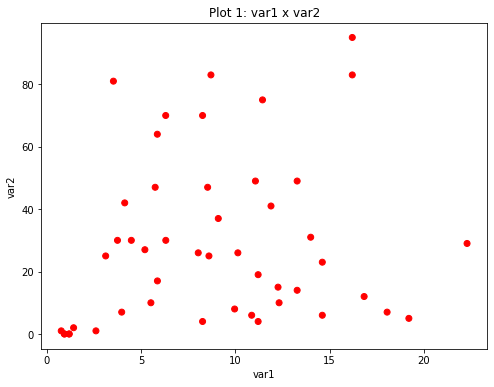

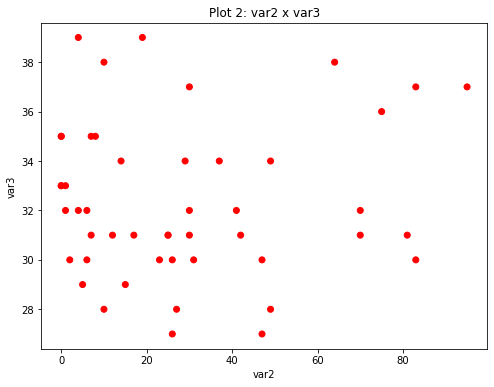

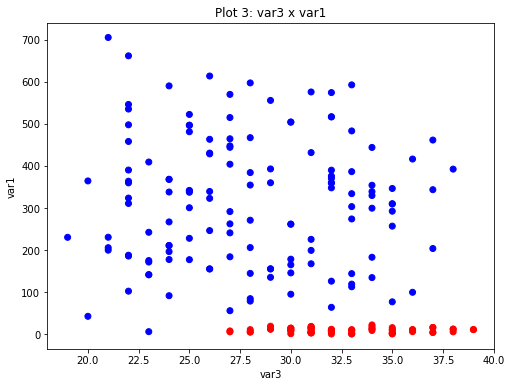

In [45]:

# Plot 1: var1 x var2
plt.figure(figsize=(8, 6))
plt.scatter(df1['var1'], df1['var2'], c=df1['cluster'].map({True: 'red', False: 'blue'}))
plt.xlabel('var1')
plt.ylabel('var2')
plt.title('Plot 1: var1 x var2')
plt.show()

# Plot 2: var2 x var3
plt.figure(figsize=(8, 6))
plt.scatter(df1['var2'], df1['var3'], c=df1['cluster'].map({True: 'red', False: 'blue'}))
plt.xlabel('var2')
plt.ylabel('var3')
plt.title('Plot 2: var2 x var3')
plt.show()

# Plot 3: var3 x var1
plt.figure(figsize=(8, 6))
plt.scatter(df1['var3'], df1['var1'], c=df1['cluster'].map({True: 'red', False: 'blue'}))
plt.xlabel('var3')
plt.ylabel('var1')
plt.title('Plot 3: var3 x var1')
plt.show()


In [ ]:
## MODELOS DE DETECTACAO 
outliers_fraction = 0.3
anomaly_algorithms = [
    ("One-Class SVM", svm.OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.1)),
    (
        "One-Class SVM (SGD)",
        make_pipeline(
            Nystroem(gamma=0.1, random_state=42, n_components=150),
            SGDOneClassSVM(
                nu=outliers_fraction,
                shuffle=True,
                fit_intercept=True,
                random_state=42,
                tol=1e-6,
            ),
        ),
    ),
    (
        "Isolation Forest",
        IsolationForest(contamination=outliers_fraction, random_state=42),
    ),
]


### Simulação com B modelos par B dataframes com permutação entre os tempos

In [52]:
# Somar o número de colunas com cluster == True
num_cluster_true = (df['cluster'] == True).sum()

# Exibir o resultado
print("Número de colunas com cluster == True:", num_cluster_true)

Número de colunas com cluster == True: 66


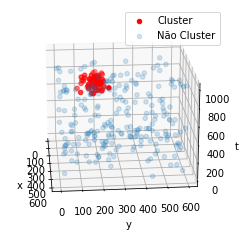

In [53]:
# Crie uma figura e um subplot 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

def update(frame):
    ax.view_init(elev=20, azim=frame*5)  # Atualize o ângulo de visualização
    ax.clear()  # Limpe o subplot
    # Plote os pontos pertencentes ao cluster em cor diferente
    ax.scatter(df[df['cluster'] == 1]['x'], df[df['cluster'] == 1]['y'], df[df['cluster'] == 1]['t'], c='red', label='Cluster')
    # Plote os pontos não pertencentes ao cluster com maior transparência
    ax.scatter(df[df['cluster'] == 0]['x'], df[df['cluster'] == 0]['y'], df[df['cluster'] == 0]['t'], alpha=0.2, label='Não Cluster')

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('t')
    ax.legend()

# Crie a animação
animation = FuncAnimation(fig, update, frames=72, interval=50)

# Salve a animação em formato de GIF
animation.save('animacao.gif', writer='pillow')

# Mostrar o gráfico
plt.show()

In [54]:
B = 100
df_base = criar_variaveis(df.sort_values("t"))

# Dicionário para armazenar o tempo médio de duração de cada modelo
tempo_medio = {}

for name, algorithm in anomaly_algorithms:
    # Inicializar a coluna de contagem para cada modelo
    df_base[name] = 0
    
    # List para armazenar o tempo de duração de cada iteração do modelo
    tempos = []

    for b in range(B):
        # CRIANDO O BANCO DE DADOS b PARA TREINAR O MODELO
        df_b = df.copy()
        df_b['t'] = np.random.permutation(df_b['t'])
        df_b = criar_variaveis(df_b)
        df_b = df_b[['var1','var2','var3']]

        # INICIO DO TREINAMENTO DO MODELO
        t0 = time.time()

        # TREINO DO MODELO
        algorithm.fit(df_b.values)
        
        # TEMPO FINAL
        t1 = time.time()

        # PREDIZER OS OUTLIERS EM NA BASE ORIGINAL
        if name == "Local Outlier Factor":
            y_pred = algorithm.fit_predict(df_base[['var1', 'var2', 'var3']].values)
        else:
            y_pred = algorithm.fit(df_b.values).predict(df_base[['var1', 'var2', 'var3']].values)
        
        # Atualizar a coluna de contagem para cada observação classificada como anomalia
        df_base[name] += (y_pred == -1).astype(int)
        
        # Armazenar o tempo de duração da iteração atual do modelo
        tempos.append(t1 - t0)
    
    # Calcular o tempo médio de duração do modelo
    tempo_medio[name] = np.mean(tempos)
    
    # Imprimir o tempo médio de duração do modelo
    print(f"{name} - Média de tempo de duração: {tempo_medio[name]:.2f}s")

One-Class SVM - Média de tempo de duração: 0.01s
One-Class SVM (SGD) - Média de tempo de duração: 0.02s
Isolation Forest - Média de tempo de duração: 0.20s


In [49]:
df_base.to_csv('base_modelos_occ_anomalia03.csv', index=False)

In [43]:
df_base

,x,y,t,cluster,var1,var2,var3,One-Class SVM,One-Class SVM (SGD),Isolation Forest
106,355.225159,196.020529,47,False,77.068495,0,0,40,0,0
69,57.659045,414.015012,53,False,463.260820,0,0,28,0,0
86,313.948832,489.314291,57,False,164.535319,0,0,0,0,0
172,119.997915,380.398619,58,False,204.741301,0,0,53,0,0
272,202.895371,104.863202,67,False,333.561697,0,0,27,0,0
...,...,...,...,...,...,...,...,...,...,...
297,517.314910,282.389370,979,False,463.202306,0,0,0,0,0
41,262.219172,118.232568,984,False,114.182860,0,0,73,0,0
277,479.521552,531.782800,998,False,558.410212,0,0,36,0,0
84,339.960873,492.460272,999,False,165.273857,0,0,0,0,0


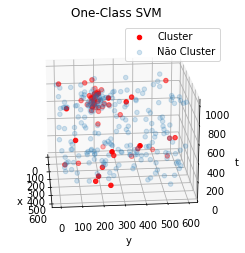

In [55]:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

def update(frame):
    ax.view_init(elev=20, azim=frame*5)  # Atualize o ângulo de visualização
    ax.clear()  # Limpe o subplot
    ax.scatter(df_base[df_base['One-Class SVM'] > 80]['x'], df_base[df_base['One-Class SVM'] > 80]['y'], df_base[df_base['One-Class SVM'] > 80]['t'], c='red', label='Cluster')
    ax.scatter(df_base[df_base['One-Class SVM'] <= 80]['x'], df_base[df_base['One-Class SVM'] <= 80]['y'], df_base[df_base['One-Class SVM'] <= 80]['t'], alpha=0.2, label='Não Cluster')
    ax.set_title('One-Class SVM')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('t')
    ax.legend()

animation = FuncAnimation(fig, update, frames=72, interval=50)
animation.save('One-Class SVM2.gif', writer='pillow')
plt.show()  # Exibe a animação

IndexError: list index out of range

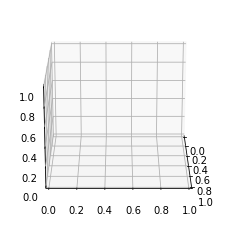

In [56]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

def update(frame):
    ax.view_init(elev=20, azim=frame*5)  # Atualize o ângulo de visualização
    ax.clear()  # Limpe o subplot
    ax.scatter(df_base[df_base['One-Class SVM (SGD)'] > 70]['x'], df_base[df_base['One-Class SVM (SGD)'] > 80]['y'], df_base[df_base['One-Class SVM (SGD)'] > 70]['t'], c='red', label='Cluster')
    ax.scatter(df_base[df_base['One-Class SVM (SGD)'] <= 70]['x'], df_base[df_base['One-Class SVM (SGD)'] <= 80]['y'], df_base[df_base['One-Class SVM (SGD)'] <= 70]['t'], alpha=0.2, label='Não Cluster')
    ax.set_title('One-Class SVM (SGD)')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('t')
    ax.legend()

animation = FuncAnimation(fig, update, frames=72, interval=50)
animation.save('One-Class SVM (SGD)2.gif', writer='pillow')
plt.show()  # Exibe a animação

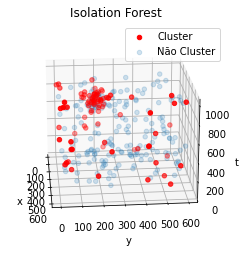

In [57]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

def update(frame):
    ax.view_init(elev=20, azim=frame*5)  # Atualize o ângulo de visualização
    ax.clear()  # Limpe o subplot
    ax.scatter(df_base[df_base['Isolation Forest'] > 70]['x'], df_base[df_base['Isolation Forest'] > 70]['y'], df_base[df_base['Isolation Forest'] > 70]['t'], c='red', label='Cluster')
    ax.scatter(df_base[df_base['Isolation Forest'] <= 70]['x'], df_base[df_base['Isolation Forest'] <= 70]['y'], df_base[df_base['Isolation Forest'] <= 70]['t'], alpha=0.2, label='Não Cluster')
    ax.set_title('Isolation Forest')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('t')
    ax.legend()

animation = FuncAnimation(fig, update, frames=72, interval=50)
animation.save('Isolation Forest2.gif', writer='pillow')
plt.show()  # Exibe a animação

In [27]:
df_base

,var1,var2,var3,t,One-Class SVM,One-Class SVM (SGD),Isolation Forest,x,y
179,518.488136,-137,1,11,100,99,0,19.103358,271.093010
285,294.731770,-705,1,11,100,99,92,88.884517,148.439253
207,506.610945,0,0,19,20,0,0,272.218107,29.214178
153,285.151921,0,0,23,1,94,0,369.335739,63.543693
271,533.700335,0,0,24,34,0,0,525.903147,21.620290
...,...,...,...,...,...,...,...,...,...
297,463.202306,0,0,979,0,0,0,517.314910,282.389370
41,114.182860,0,0,984,66,0,0,262.219172,118.232568
277,558.410212,0,0,998,46,0,0,479.521552,531.782800
143,594.139157,0,0,999,60,0,0,535.154013,27.604387


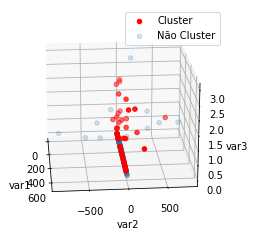

In [48]:
# Crie uma figura e um subplot 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

def update(frame):
    ax.view_init(elev=20, azim=frame*5)  # Atualize o ângulo de visualização
    ax.clear()  # Limpe o subplot
    # Plote os pontos pertencentes ao cluster em cor diferente
    ax.scatter(df_base[df_base['cluster'] == 1]['var1'], df_base[df_base['cluster'] == 1]['var2'], df_base[df_base['cluster'] == 1]['var3'], c='red', label='Cluster')
    # Plote os pontos não pertencentes ao cluster com maior transparência
    ax.scatter(df_base[df_base['cluster'] == 0]['var1'], df_base[df_base['cluster'] == 0]['var2'], df_base[df_base['cluster'] == 0]['var3'], alpha=0.2, label='Não Cluster')

    ax.set_xlabel('var1')
    ax.set_ylabel('var2')
    ax.set_zlabel('var3')
    ax.legend()

# Crie a animação
animation = FuncAnimation(fig, update, frames=72, interval=50)

# Salve a animação em formato de GIF
animation.save('teste.gif', writer='pillow')

# Mostrar o gráfico
plt.show()